<a href="https://colab.research.google.com/github/CharlyWheels/Carlos_Rueda_TFM/blob/colab/Epc_CNN_padding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
df_epc = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/epc.csv', engine='python')
df_epc.shape

(804691, 38)

In [3]:
df_epc.drop(['id', 'reference','epc','score', 'count', 'maxRssiValue',
        'minRssiValue', 'maxTimeStamp', 'minTimeStamp', 'rssiDiff',
        'seenDiff', 'antenna1', 'antenna2', 'antenna3', 'antenna4', 'ts_percent0',
       'ts_percent1', 'ts_percent2', 'ts_percent3', 'ts_percent4',
       'ts_percent5', 'ts_percent6', 'ts_percent7', 'ts_percent8',
       'rv_percent0', 'rv_percent1', 'rv_percent2', 'rv_percent3',
       'rv_percent4', 'rv_percent5', 'rv_percent6', 'rv_percent7',
       'rv_percent8', 'lastModification'], axis=1, inplace=True)
df_epc.shape

(804691, 4)

In [4]:
df_epc = df_epc.dropna(subset=['desired'])

In [5]:
df_epc["desired"] = df_epc["desired"].astype(int)

<ipython-input-5-0a63cd044442>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epc["desired"] = df_epc["desired"].astype(int)


In [6]:
from sklearn.utils import resample

df_epc_majority = df_epc[df_epc.desired==1]
df_epc_minority = df_epc[df_epc.desired==0]

print(df_epc_majority.shape)
print(df_epc_minority.shape)

(757822, 4)
(4731, 4)


In [7]:
df_epc_minority_upsampled = resample(df_epc_minority, replace=True, n_samples=757822, random_state=123)

In [8]:
df_epc_upsampled = pd.concat([df_epc_majority, df_epc_minority_upsampled])

In [9]:
X = []
Y = []
for index, row in df_epc_upsampled.iterrows():
  X_ts = np.pad(np.array(json.loads(row['timeStamp'])), (175 - len(np.array(json.loads(row['timeStamp']))), 0), mode='constant')
  X_rv = np.pad(np.array(json.loads(row['rssiValue'])), (175 - len(np.array(json.loads(row['rssiValue']))), 0), mode='constant')
  X_an = np.pad(np.array(json.loads(row['antennas'])), (175 - len(np.array(json.loads(row['antennas']))), 0), mode='constant')
  Y_item = row['desired']
  X_item = np.array(list(zip(X_ts,X_rv,X_an)))
  X.append(X_item)
  Y.append(Y_item)

X = np.array(X)
Y = np.array(Y)
print(X.shape)
print(Y.shape)

(1515644, 175, 3)
(1515644,)


In [11]:
from keras.utils.np_utils import to_categorical
y = np.array(to_categorical(Y))

In [12]:
from keras.layers import Embedding,Dense,LSTM,Dropout,Flatten,BatchNormalization,Conv1D,GlobalMaxPooling1D,MaxPooling1D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Conv1D(16, kernel_size=3, activation='relu', input_shape=(175,3)))
model.add(Conv1D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
es1 = EarlyStopping(monitor='loss', mode='min',patience=5)

In [14]:
history_cnn = model.fit(X, y, epochs=100, batch_size=300 ,shuffle=True , callbacks=[es1])

Epoch 1/100
5053/5053 [==============================] - 28s 3ms/step - loss: 0.3024 - accuracy: 0.8865
Epoch 2/100
5053/5053 [==============================] - 17s 3ms/step - loss: 0.2478 - accuracy: 0.8957
Epoch 3/100
5053/5053 [==============================] - 17s 3ms/step - loss: 0.2361 - accuracy: 0.8999
Epoch 4/100
5053/5053 [==============================] - 17s 3ms/step - loss: 0.2296 - accuracy: 0.9022
Epoch 5/100
5053/5053 [==============================] - 17s 3ms/step - loss: 0.2325 - accuracy: 0.9040
Epoch 6/100
5053/5053 [==============================] - 17s 3ms/step - loss: 0.2302 - accuracy: 0.9056
Epoch 7/100
5053/5053 [==============================] - 17s 3ms/step - loss: 0.2182 - accuracy: 0.9077
Epoch 8/100
5053/5053 [==============================] - 17s 3ms/step - loss: 0.2332 - accuracy: 0.9082
Epoch 9/100
5053/5053 [==============================] - 17s 3ms/step - loss: 0.2196 - accuracy: 0.9090
Epoch 10/100
5053/5053 [==============================] - 17s 3m

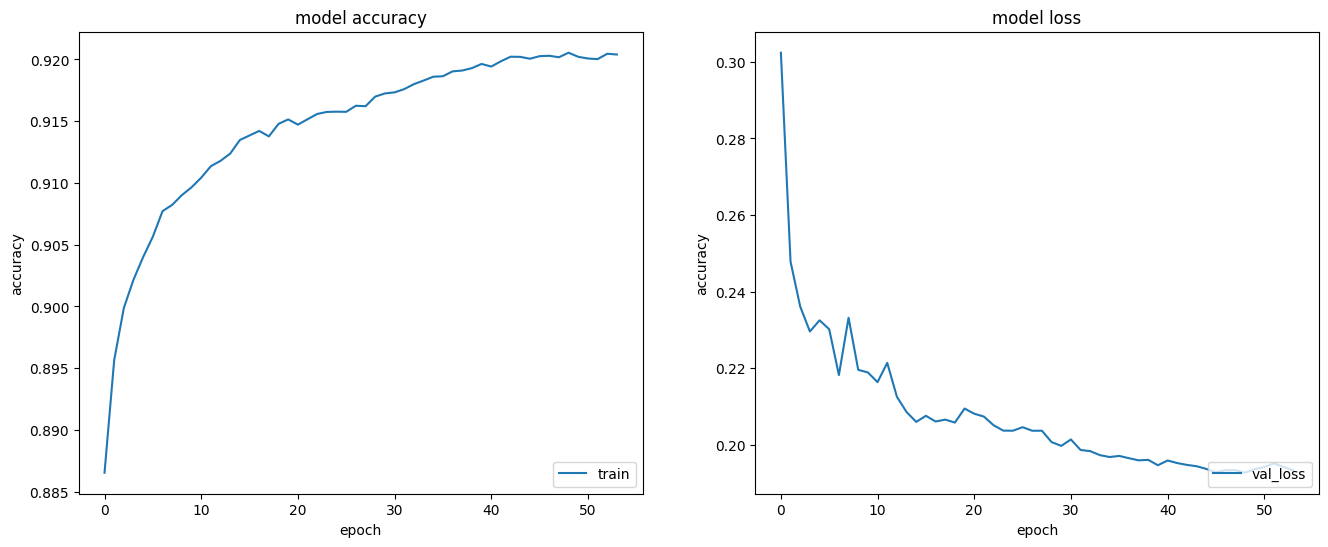

In [17]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize = (16,6))
axes[0].plot(history_cnn.history['accuracy'])
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='lower right')

axes[1].plot(history_cnn.history['loss'])
axes[1].set_title('model loss')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['val_loss', 'loss'], loc='lower right')